In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import os
from IPython.display import display, HTML
from operator import itemgetter


In [2]:
# Function to check for presence of files for a given MIP, scenario, frequency, and variable; and prepare list of files to use.
# Also displays status of each model and number of usable ensemble members.
def checkModels(mip,scenario,freq,varname,nminens=1,verbose=True):
    #================================================================================================================
    # ARGUMENT LIST:
    # mip (string) = Intercomparison project, e.g. 'CMIP', 'ScenarioMIP', etc
    # scenario (string) = experiment or scenario, e.g. 'historical', 'ssp585', etc
    # freq (string) = frequency, e.g. 'Amon' for monthly means
    # varname (string) = variable to extract, e.g. 'pr' for precip, 'ts' for surface temperature
    # nminens (integer, optional) = minimum number of ensemble members required for model to be included. 1 by default.
    # verbose (boolean, optional) = if True, table of models is displayed
    #=================================================================================================================
    # REQUIRED PACKAGES:
    #=================================================================================================================
    import numpy as np
    import pandas as pd
    import os
    from IPython.display import display, HTML
    #=================================================================================================================
    dirn = '/global/cfs/projectdirs/m3522/cmip6/CMIP6/'
    dirn = '/global/cfs/projectdirs/m3522/cmip6/CMIP6/'
    centers = os.listdir(dirn+mip+'/')
    modeln = []
    modellist = [] 
    shortmodeln = [] # These 2 are to display model status at the end.
    modelstatus = [] 
    incmodel = [] # List of included models' names
    for center in centers:
        centern = dirn + mip + '/' + center + '/'
        models = os.listdir(centern)
        for model in models:
            thismodeln = centern + model + '/' + scenario + '/'
            shortmodeln.append(center+'/'+model)
            freqflag = 0
            varflag = 0
            if os.path.isdir(thismodeln): # Does this scenario for this model exist?
                ensemblelist = []
                for ensmem in os.scandir(thismodeln):
                    ensmemlist = []
                    if os.path.isdir(ensmem.path+'/'+freq+'/'): # Does this frequency exist?
                        if os.path.isdir(ensmem.path+'/'+freq+'/'+varname+'/'): # Does this variable exist?
                            for grid in os.scandir(ensmem.path+'/'+freq+'/'+varname+'/'):
                            # Choose only most recent version:
                                versions = sorted(os.scandir(grid),key=lambda e: e.name,reverse=True)
                                for f in os.scandir(versions[0]):
                                    ensmemlist.append(f.path)
                                if ensmemlist:    # Check whether files exist: empty version directories can cause issues
                                    ensemblelist.append(ensmemlist)
                                if not(thismodeln in modeln):
                                    modeln.append(thismodeln)
                        else:
                            varflag = varflag + 1
                    else:
                        freqflag = freqflag + 1 
                    
                if freqflag==len(os.listdir(thismodeln)): # Missing frequency
                    modelstatus.append(freq+' missing')
                elif varflag==len(os.listdir(thismodeln)): # Missing variable
                    modelstatus.append(varname+' missing')
                elif varflag+freqflag>=len(os.listdir(thismodeln)): # Missing a combination of frequency and variable
                    modelstatus.append('Too many incomplete ensemble members')
                elif len(ensemblelist)<nminens: # Too few ensemble members
                    modelstatus.append('Too few ensemble members')
                elif varflag>0 and varflag<len(os.listdir(thismodeln)): # Some ensemble members lack the variable
                    modelstatus.append('Included '+str(len(ensemblelist))+' ensemble members, excluded '+str(varflag)+' due to missing '+varname)
                    modellist.append(ensemblelist)
                    incmodel.append(center+'/'+model)
                elif freqflag>0 and freqflag<len(os.listdir(thismodeln)): # Some ensemble members lack the frequency
                    modelstatus.append('Included '+str(len(ensemblelist))+' ensemble members, excluded '+str(freqflag)+' due to missing '+freq)
                    modellist.append(ensemblelist)
                    incmodel.append(center+'/'+model)
                else:                                # Everything's ok
                    modelstatus.append('Included '+str(len(ensemblelist))+' ensemble members') 
                    modellist.append(ensemblelist)
                    incmodel.append(center+'/'+model)
            else:                                    # Scenario missing
                modelstatus.append(scenario+' missing') 
    # End of loops
    
    # Display status of all models
    if verbose:
        d1 = {'Model':shortmodeln,'Status':modelstatus}
        df1 = pd.DataFrame(d1, columns=['Model','Status'])
        pd.options.display.max_rows
        pd.set_option('display.max_colwidth', -1)
        display(df1)
    # Display numbers of ensemble members for each included model
    d2 = {'Included models':incmodel,'Number of Ensemble Members':[len(modellist[x]) for x in np.arange(len(modellist))]}
    df2 = pd.DataFrame(d2, columns=['Included models','Number of Ensemble Members'])
    if verbose:
        display(df2)
    return modellist, df2 # modellist is a list of lists of filenames. Elements can be accessed as modellist[model][ensemblemember][filenumber], as required for ensemble-mean scripts.
# End of function

In [3]:
# Function to check whether the models have output for the required range of years. 
# Ensemble members and models for which the years are not available are removed from the list.
# For monthly data, incomplete ensemble members (years in the middle missing) are detected and removed. 
# For other frequencies, the output includes ensemble members with gaps as long as years within the range are available.
def checkYears(modellist,modelnamesFrame,st,en,nminens=1,verbose=True):
    #================================================================================================================
    # ARGUMENT LIST:
    # modellist (list of lists) = list of files with model output, organized as output from checkModels
    # st (integer) = first year in range
    # en (integer) = last year in range
    # nminens (integer, optional) = minimum number of ensemble members required for model to be included. 1 by default.
    # verbose (boolean, optional) = Prints the model and ensemble numbers of the deleted files. True by default.
    #=================================================================================================================
    # REQUIRED PACKAGES:
    #=================================================================================================================
    import numpy as np
    import pandas as pd
    import os
    from IPython.display import display, HTML
    import xarray as xr
    import copy
    #=================================================================================================================
    shortlist = copy.deepcopy(modellist)
    shortFrame = modelnamesFrame.copy(deep=True)
    modelnum = 0
    ctr1 = 0
    for model in modellist:
        ensnum = 0
        ctr2 = 0
        for ensemblemember in model:  # ensemblemember is a list of files (separated by years) in that member of the ensemble
            # wrb, decode all time to cf_time rather than default numpy.datetime64 because 
            #  this otherwise fails when attempting to load data with proleptic gregorian calendar
            #  that goes beyond pandas year range of 2262 (CMIP6 output often goes to year 2300)
            #print(ensemblemember)
            #dat = xr.open_mfdataset(ensemblemember,combine='by_coords')
            dat = xr.open_mfdataset(ensemblemember,combine='by_coords',use_cftime=True)
            # not successful:  this deals with overlapping times (e.g. NorESM model has one file ending Dec 2040, and the next starting Jan 2040)
            #dat = xr.open_mfdataset(ensemblemember,use_cftime=True,compat='override',coords='minimal')
            if '/Amon/' in ensemblemember[0]: #Check if this is monthly data
                monlen = 12*(1+(int(dat.time.dt.year[-1])-int(dat.time.dt.year[0])))
                if int(dat.time.dt.year[0])>st or int(dat.time.dt.year[-1])<en or len(dat.time.values)<monlen:
                    if verbose:
                        if len(dat.time.values)<monlen:
                            print('Removing ensemble member '+str(ctr2)+' from model number '+str(ctr1)+'. Incomplete record. ')
                        else:
                            print('Removed ensemble member '+str(ctr2)+' from model number '+str(ctr1)+'. Years: '+str(int(dat.time.dt.year[0]))+' to '+str(int(dat.time.dt.year[-1])))
                    del shortlist[modelnum][ensnum]
                    ensnum = ensnum - 1
            else:
                if int(dat.time.dt.year[0])>st or int(dat.time.dt.year[-1])<en:
                    if verbose:
                        print('Removing ensemble member '+str(ctr2)+' from model number '+str(ctr1)+'. Years: '+str(int(dat.time.dt.year[0]))+' to '+str(int(dat.time.dt.year[-1])))
                    del shortlist[modelnum][ensnum]
                    ensnum = ensnum - 1
            ensnum = ensnum + 1
            ctr2 = ctr2+1
        if len(shortlist[modelnum])<nminens:
            del shortlist[modelnum]
            shortFrame = shortFrame.drop([modelnum])
            if verbose:
                print('Removing model number '+str(ctr1))
            modelnum = modelnum-1
        modelnum = modelnum + 1
        ctr1 = ctr1+1
        shortFrame.index = range(len(shortFrame))
    return shortlist, shortFrame

In [4]:
# Function to grab all available data for a given MIP, scenario, frequency, variable. Returns a list of dataArrays corresponding to ensemble members.
def loadData(modellist,varname):
    #================================================================================================================
    # ARGUMENT LIST:
    # varname (string) = variable to extract, e.g. 'pr' for precip, 'ts' for surface temperature
    #===========================================================
    # REQUIRED PACKAGES (the rest are loaded in modellist below)
    #===========================================================
    import xarray as xr
    #===========================================================
    # LOAD MODELLIST BEFORE RUNNING THIS
    #===========================================================
    modelnum = 0
    allDat = []
    for model in modellist:
        ensnum = 0
        for ensemblemember in model:  # ensemblemember is a list of files (separated by years) in that member of the ensemble
            # wrb: convert all to cf_time to avoid weird issues with proleptic gregorian calendar:
            #dat = xr.open_mfdataset(ensemblemember,combine='by_coords')
            dat = xr.open_mfdataset(ensemblemember,combine='by_coords',use_cftime=True)
            datvar = dat[varname]
            if ensnum:
                ensDatVar = xr.concat([ensDatVar, datvar.expand_dims('ensmember')],dim='ensmember')
            else:
                ensDatVar = datvar.expand_dims('ensmember')
            ensnum = ensnum + 1
        allDat.append(ensDatVar)
        del ensDatVar
        modelnum = modelnum + 1
    return allDat   


In [5]:
def loadMonthMMM2D(modellist,yrstart,yrend):
    modelnum = 0
    datSeas1 = modellist[0].sel(time=slice(yrstart+'-01-01',yrend+'-12-31')).groupby('time.month').mean(
        dim=('time','ensmember'))
    datSeas1 = datSeas1.drop('height',errors='ignore')
    #print(datSeas1)
    for model in modellist:
        datSeas = model.sel(time=slice(yrstart+'-01-01',yrend+'-12-25')).groupby('time.month').mean(dim=('time','ensmember'))
        datSeas = datSeas.drop('height',errors='ignore')
        for k in datSeas.coords:
            if 'longitude' in k:
                datSeas = datSeas.rename({'longitude':'lon'})
                continue
            if 'latitude' in k:
                datSeas = datSeas.rename({'latitude':'lat'})
        if modelnum:
            # interpolate to first model's grid (by inspection we know this is 128x256, most common)
#             print(datSeas1)
#             print(datSeas)
            datSeasInterp = datSeas.chunk({'month': -1}).interp_like(datSeas1.chunk({'month': -1})).squeeze()
            #print(datSeasInterp)
            datSeasMMM = xr.concat([datSeasMMM, datSeasInterp.expand_dims(dim='model',axis=0)],dim='model')
        else:
            datSeasMMM = datSeas.expand_dims(dim='model',axis=0)
        modelnum = modelnum + 1
        #print(modelnum)
    return datSeasMMM
    

In [6]:
intvaw_modellist, intvaw_modelnames = checkModels('ScenarioMIP','ssp585','Emon','intvaw',1,False)
intvaw_modellist, intvaw_modelnames = checkYears(intvaw_modellist,intvaw_modelnames,2015,2099,nminens=1,verbose=False)

intuaw_modellist, intuaw_modelnames = checkModels('ScenarioMIP','ssp585','Emon','intuaw',1,False)
intuaw_modellist, intuaw_modelnames = checkYears(intuaw_modellist,intuaw_modelnames,2015,2099,nminens=1,verbose=False)

In [7]:
intuaw_modelnames[1:]

,Included models,Number of Ensemble Members
1,CNRM-CERFACS/CNRM-CM6-1,6
2,CNRM-CERFACS/CNRM-ESM2-1,5
3,IPSL/IPSL-CM6A-LR,1


In [8]:
intvaw_modelnames

,Included models,Number of Ensemble Members
0,CNRM-CERFACS/CNRM-CM6-1,6
1,CNRM-CERFACS/CNRM-ESM2-1,5
2,IPSL/IPSL-CM6A-LR,4


In [9]:
intuaw_SSP585 = loadData(intuaw_modellist[1:],'intuaw')
intvaw_SSP585 = loadData(intvaw_modellist,'intvaw')

In [10]:
intuaw_st=loadMonthMMM2D(intuaw_SSP585,"2015","2034")
intvaw_st=loadMonthMMM2D(intvaw_SSP585,"2015","2034")

intuaw_en=loadMonthMMM2D(intuaw_SSP585,"2080","2099")
intvaw_en=loadMonthMMM2D(intvaw_SSP585,"2080","2099")

In [11]:
orog =xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp370/r3i1p1f2/fx/orog/gr/v20190410/orog_fx_CNRM-CM6-1_ssp370_r3i1p1f2_gr.nc")
m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.lat*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.orog.differentiate("lon")/(m_per_degreelat*coslat)
ddyorog = orog.orog.differentiate("lat")/m_per_degreelat


In [12]:
vimf_gradz_st = intuaw_st*ddxorog+intvaw_st*ddyorog
vimf_gradz_en = intuaw_en*ddxorog+intvaw_en*ddyorog

In [13]:
vimf_gradz_st_MMM = vimf_gradz_st.mean(["model","month"])
vimf_gradz_en_MMM = vimf_gradz_en.mean(["model","month"])

In [24]:
#Convert to kg/m/s to mm/day : divide by mean atmospheric mass 1013hPa/9.81m/s2 = 10326 kg/m2 to obtain m/s;
#then multiply by 86400 *1 to obtain mm/day (1kg/m3 is the approximate density of air; you then get kg/m2/day which is mm/day)

vimf_gradz_st_MMM = vimf_gradz_st_MMM*86400*9.81/101325
vimf_gradz_en_MMM = vimf_gradz_en_MMM*86400*9.81/101325



Text(0.5, 1.0, 'CMIP6 MMM, 2080-2099 minus 2015-2034 | <uq>.grad(z)')

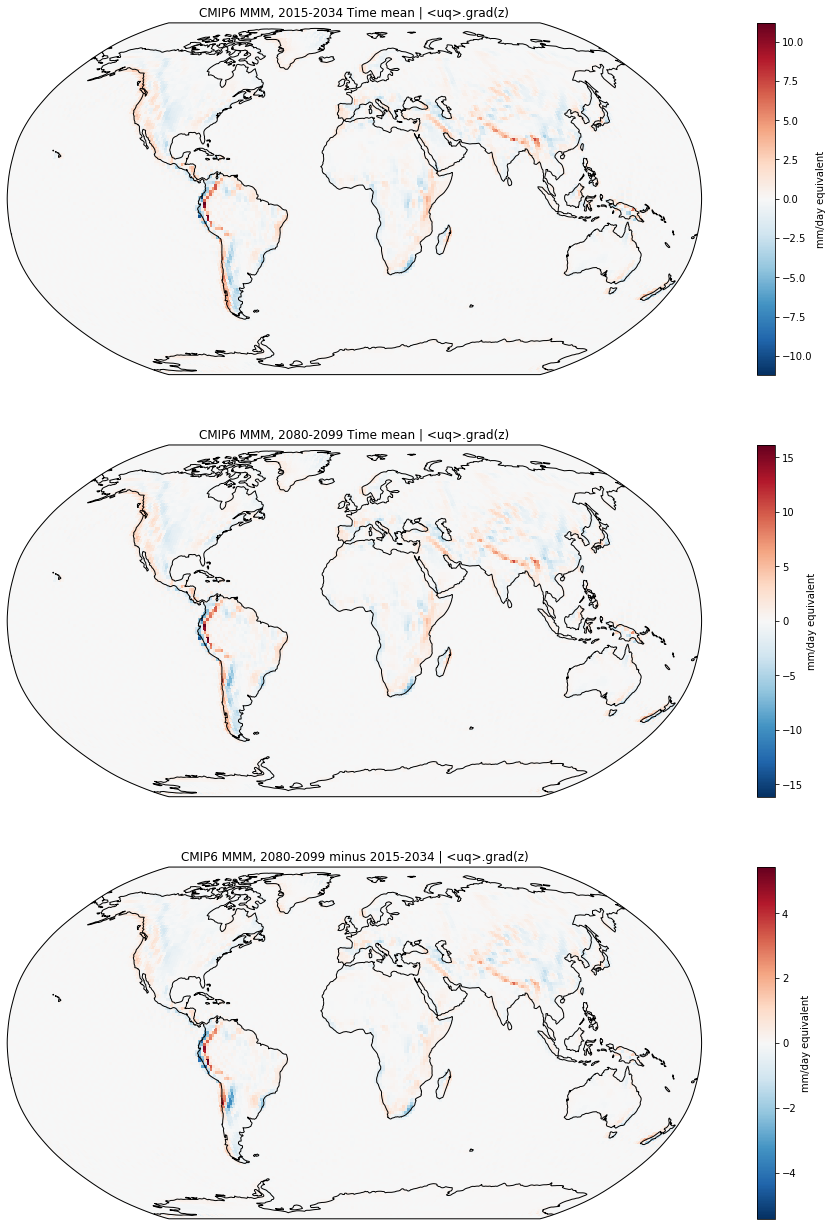

In [25]:

fig, ax = plt.subplots(3,1,figsize=(20,22),subplot_kw={'projection': ccrs.Robinson()})
vimf_gradz_st_MMM.plot(ax=ax[0],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day equivalent"})
vimf_gradz_en_MMM.plot(ax=ax[1],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day equivalent"})
(vimf_gradz_en_MMM-vimf_gradz_st_MMM).plot(ax=ax[2],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day equivalent"})
for a in ax : a.coastlines()
ax[0].set_title("CMIP6 MMM, 2015-2034 Time mean | <uq>.grad(z)")
ax[1].set_title("CMIP6 MMM, 2080-2099 Time mean | <uq>.grad(z)")
ax[2].set_title("CMIP6 MMM, 2080-2099 minus 2015-2034 | <uq>.grad(z)")


Text(0.5, 1.0, 'CMIP6 MMM, <uq>.grad(z) % change ')

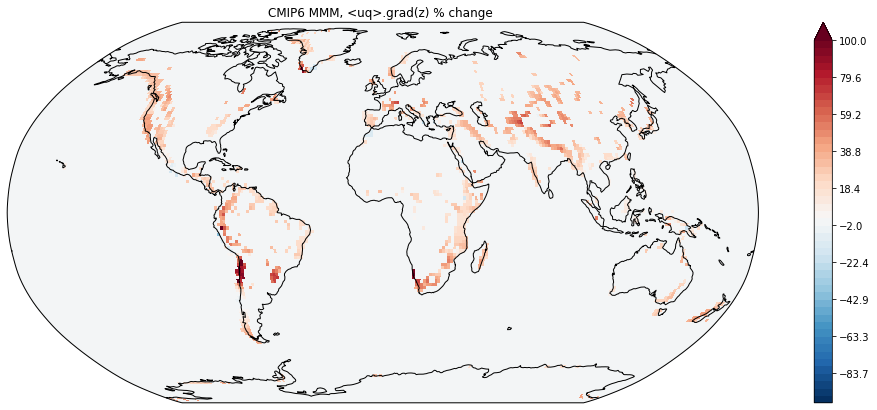

In [35]:
mask = 1.*(vimf_gradz_st_MMM>0.5)

fig, ax = plt.subplots(1,1,figsize=(20,7),subplot_kw={'projection': ccrs.Robinson()})
(mask*100*(xr.ufuncs.maximum(vimf_gradz_en_MMM,0.)-xr.ufuncs.maximum(vimf_gradz_st_MMM,0.))/(xr.ufuncs.maximum(vimf_gradz_st_MMM,0.)+0.2)).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-100,100))
ax.coastlines()
ax.set_title("CMIP6 MMM, <uq>.grad(z) % change ")



In [30]:
def spatial_mean(da):
    """Compute spatial mean of a DataArray"""
    if type(da)==int:
        return da
    coslat = xr.ufuncs.cos(xr.ufuncs.deg2rad(da.lat))
    weight_factor = coslat / coslat.mean('lat')
    return (da*weight_factor).mean(['lat','lon'])


In [31]:
print("Percent change of global mean <uq>.grad(z) : %.1f %%"%(100*(spatial_mean(xr.ufuncs.maximum(vimf_gradz_en_MMM,0.))/spatial_mean(xr.ufuncs.maximum(vimf_gradz_st_MMM,0.)) -1.)))


Percent change of global mean <uq>.grad(z) : 34.0 %


In [37]:
print("Mean of the percent change in <uq>.grad(z), over points > 0.5mm/day : %.1f %%"%(spatial_mean(mask*(100*(xr.ufuncs.maximum(vimf_gradz_en_MMM,0.)-xr.ufuncs.maximum(vimf_gradz_st_MMM,0.))/(xr.ufuncs.maximum(vimf_gradz_st_MMM,0.)+0.2))) / spatial_mean(mask) ))



Mean of the percent change in <uq>.grad(z), over points > 0.5mm/day : 27.9 %


Text(0.5, 1.0, 'CMIP6 MMM, 2080-2099 minus 2015-2034 - <uq>')

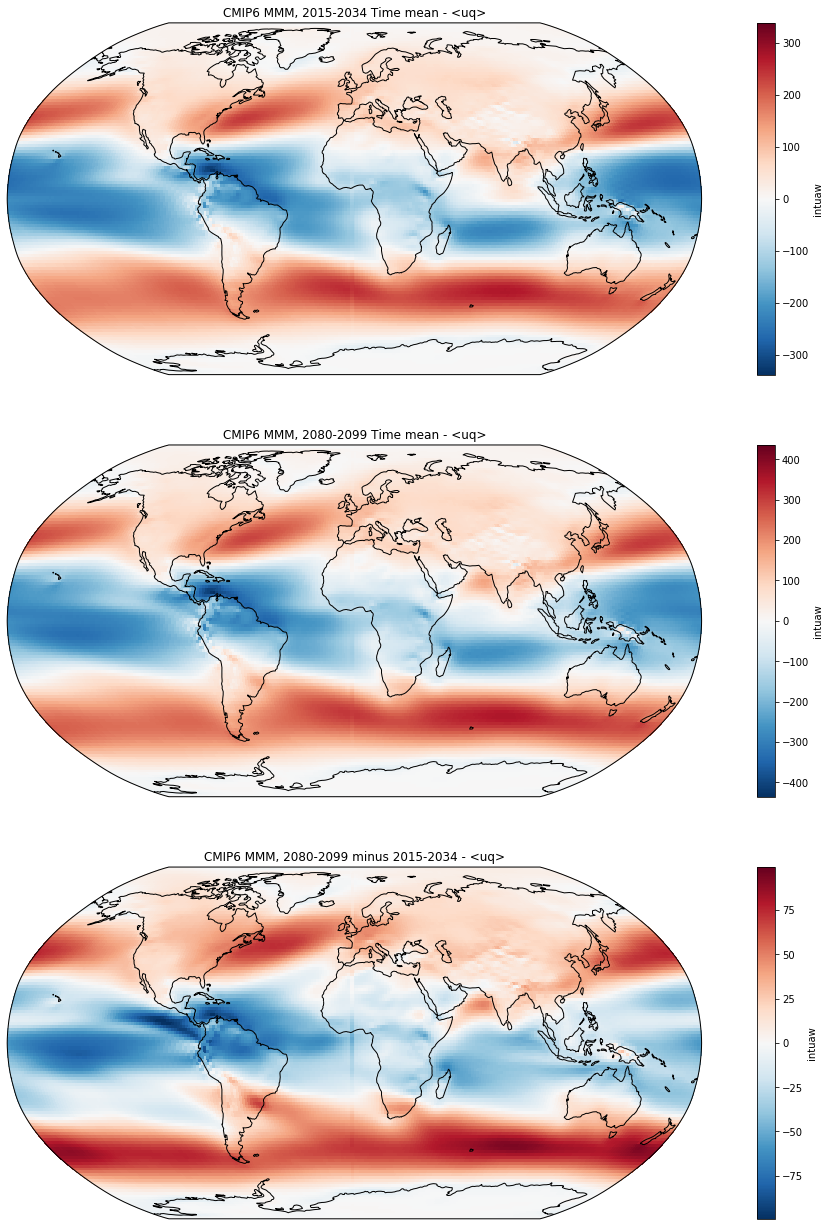

In [18]:

fig, ax = plt.subplots(3,1,figsize=(20,22),subplot_kw={'projection': ccrs.Robinson()})
intuaw_st.mean(["model","month"]).plot(ax=ax[0],transform=ccrs.PlateCarree())
intuaw_en.mean(["model","month"]).plot(ax=ax[1],transform=ccrs.PlateCarree())
(intuaw_en-intuaw_st).mean(["model","month"]).plot(ax=ax[2],transform=ccrs.PlateCarree())
for a in ax : a.coastlines()
ax[0].set_title("CMIP6 MMM, 2015-2034 Time mean - <uq>")
ax[1].set_title("CMIP6 MMM, 2080-2099 Time mean - <uq>")
ax[2].set_title("CMIP6 MMM, 2080-2099 minus 2015-2034 - <uq>")
